In [3]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm

In [4]:
from pysim.simulation import simulate

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from math import pi, cos, sin
from pysim.utils import random_hex_string
from pysim.des import Logger

In [21]:
R = 10    # circle radius
H = 1.0   # reader altitude
V = 10.0   # meters per second, reader velocity
D = 2.0   # meters, channel distance

spec = {
    'mobility': {
        'update_timeout': 0.1,
    },
    'reader': {
        'position': (R, 0, H),
        'Q': 2,
        'M': 1,
        'DR': '8',
        'trext': False,
        'sel': 'ALL',
        'tari': 6.25e-6,
        'rtcal': 15.0e-6,
        'trcal': 20.0e-6,
        'session': 0,
        'target': 'A',
        'trajectory': {
            'center': (0, 0, 0),
            'angle0': 0,
            'point_area_radius': D * 1.01,            
            'radius': R,
            'velocity': V,  # meters per second
            'altitude': H,  # meter
        },
        'stats': {
            'record_read_timestamps': False,
        }
    },
    'tags': [{
        'id': i,
        'sensitivity': -20.0,  # dBm
        'position': (cos(pi/3 * i) * R, sin(pi/3 * i) * R, 0),
        'epcid': random_hex_string(24),
        'switch_target': False,
    } for i in range(6)],
    'channel': {
        'model': 'models.channels.ConstantChannel',
        'distance': D,
        'ber': 0.0,
    },
    'propagation': {
        'model': 'models.propagation.NoLossPropagationModel',
        'distance': D,
    },
}

def update_spec(spec, path, value):
    import copy
    new_spec = copy.deepcopy(spec)
    parts = path.split('.')
    last_dict = new_spec
    for part in parts[:-1]:
        last_dict = last_dict[part]
    last_dict[parts[-1]] = value
    return new_spec

In [33]:
velocities = (16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 64.0, 96.0)
speed_specs = [update_spec(spec, 'reader.trajectory.velocity', v) for v in velocities]
sim_time_limits = [(32 - 1/12 - 0.0001) * pi * R / v for v in velocities]

# for rec in zip(speed_specs, sim_time_limits):
#     print(rec)

speed_rets = []
for a_spec, a_limit in tqdm(list(zip(speed_specs, sim_time_limits))):
    speed_rets.append(simulate(a_spec, sim_time_limit=a_limit))

for ret in speed_rets:
    print(ret)

100%|██████████| 13/13 [03:22<00:00, 15.58s/it]

{'tags': [{'id': 0, 'read_count': 2600}, {'id': 1, 'read_count': 2500}, {'id': 2, 'read_count': 2599}, {'id': 3, 'read_count': 2600}, {'id': 4, 'read_count': 2599}, {'id': 5, 'read_count': 2600}], 'c1g2_stats': {'num_collisions': 0}, 'read_timestamps': [], 'routes': [{'t_start': 0, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 1, 'last_round': 7146}, {'t_start': 3.900000000000002, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 7147, 'last_round': 14172}, {'t_start': 7.799999999999988, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 14173, 'last_round': 21318}, {'t_start': 11.699999999999974, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 21319, 'last_round': 28344}, {'t_start': 15.59999999999996, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 28345, 'last_round': 35590}, {'t_start': 19.60000000000001, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 35591, 'last_round': 42495}, {'t_start': 23.500000000000064, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 42496, 'last_round': 4964

NameError: name 'velocities' is not defined

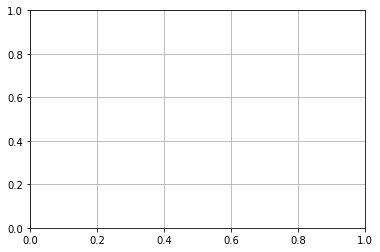

In [10]:
def get_tag_read_prob(sim_ret, num_tags=6):
    probs = []
    routes = sim_ret['routes']
#     print(routes)
    for route in routes:
        num_tags_read = len(route['tags_read'])
#         print('> num_tags_read = ', num_tags_read)
        probs.append(num_tags_read / num_tags)
    return np.mean(probs)

plt.grid()
plt.plot(velocities, [get_tag_read_prob(sr) for sr in speed_rets])

In [16]:
bers = (0.030, 0.0325, 0.0350, 0.0375, 0.0400, 0.0425, 0.0450, 0.0475, 0.050, 0.0525, 0.0550, 0.0575, 0.0600)
ber_specs = [update_spec(spec, 'channel.ber', ber) for ber in bers]
sim_time_limit = (12 - 1/12 - 0.0001) * pi * R / V

# for rec in zip(speed_specs, sim_time_limits):
#     print(rec)

ber_rets = []
for spec in tqdm(ber_specs):
    ber_rets.append(simulate(spec, sim_time_limit))

for ret in ber_rets:
    print(ret)

100%|██████████| 13/13 [06:01<00:00, 27.80s/it]

{'tags': [{'id': 0, 'read_count': 26}, {'id': 1, 'read_count': 35}, {'id': 2, 'read_count': 33}, {'id': 3, 'read_count': 35}, {'id': 4, 'read_count': 34}, {'id': 5, 'read_count': 32}], 'c1g2_stats': {'num_collisions': 0}, 'read_timestamps': [], 'routes': [{'t_start': 0, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 1, 'last_round': 11526}, {'t_start': 6.099999999999994, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 11527, 'last_round': 23503}, {'t_start': 12.399999999999972, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 23504, 'last_round': 35362}, {'t_start': 18.699999999999996, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 35363, 'last_round': 47246}, {'t_start': 25.000000000000085, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 47247, 'last_round': 59116}, {'t_start': 31.300000000000175, 'tags_read': {0, 1, 2, 3, 4, 5}, 'first_round': 59117, 'last_round': 70616}]}
{'tags': [{'id': 0, 'read_count': 16}, {'id': 1, 'read_count': 15}, {'id': 2, 'read_count': 35}, {'id': 3, 'rea

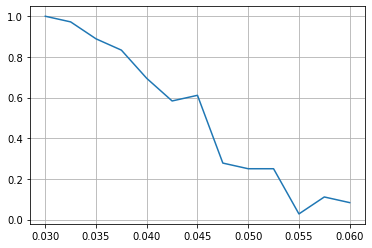

In [17]:
plt.grid()
plt.plot(bers, [get_tag_read_prob(sr) for sr in ber_rets])

In [133]:
dist_spec = update_spec(spec, 'reader.stats.record_read_timestamps', True)
dist_spec = update_spec(dist_spec, 'channel.ber', 0.03)
dist_ret = simulate(dist_spec, sim_time_limit)

<ipython-input-134-6c979a8d1887>:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax0.stem(time_intervals)
<ipython-input-134-6c979a8d1887>:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax3.stem(time_intervals)


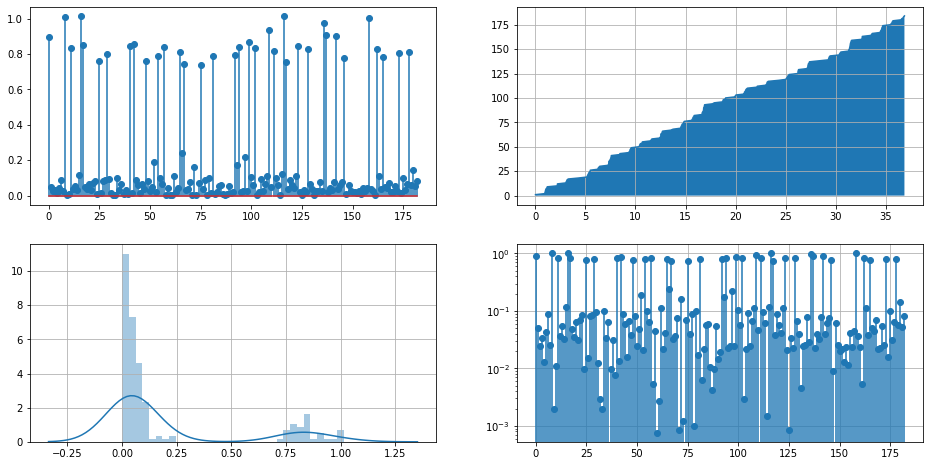

In [134]:
timestamps = np.asarray(dist_ret['read_timestamps'])
time_intervals = np.diff(timestamps)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

ax0.stem(time_intervals)
ax1.plot(timestamps, range(1, len(timestamps) + 1))
ax1.fill_between(timestamps, range(1, len(timestamps) + 1))

import seaborn as sns
sns.distplot(time_intervals, ax=ax2)

ax3.stem(time_intervals)
ax3.set_yscale('log')
ax3.grid()

ax1.grid()
ax2.grid()